### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2023 Semester 2

## Assignment 1

**Student Name:**    `Zimo Peng`

**Student ID:**     `1143743`


This iPython notebook is a template which you should use for your Assignment 1 submission. This file should be submitted at the **Assignment 1** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a written report explaining your results at the **Assignment 1** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 0. Laplacian pyramid compression
You can use the code below to check how much a quantized Laplacian pyramid representation compresses an image.

In [2]:
imSize = 256 # image height/width (assume image is square)
bitsPerLevel = [2,3,4,5,6,7,8] # bits used to encode each level of pyramid

# Image size before compression, in bits (assume uint8 grayscale)
sizeUncompressed = 8 * imSize * imSize
print('Uncompressed size = '+str(sizeUncompressed)+' bits')

# Image size after compression, in bits
sizeCompressed = 0
for i in range(len(bitsPerLevel)):
    sizeCompressed = sizeCompressed + (bitsPerLevel[i]*(imSize/(pow(2,i)))*(imSize/(pow(2,i))))
print('Compressed size = '+str(sizeCompressed)+' bits')

print(str(round(100*sizeCompressed/sizeUncompressed))+'% of original')

Uncompressed size = 524288 bits
Compressed size = 203840.0 bits
39% of original


### 1. Laplacian image pyramid

[[ -1   2   1 ...  -3  -1  -1]
 [  3  -3   0 ...   0   2   0]
 [ -1   2   1 ...  -2  -1  -1]
 ...
 [ -8  10   1 ...  12  13 -10]
 [ -3   1   3 ...   7   4 -13]
 [ -4   0   2 ...   5   3 -14]]


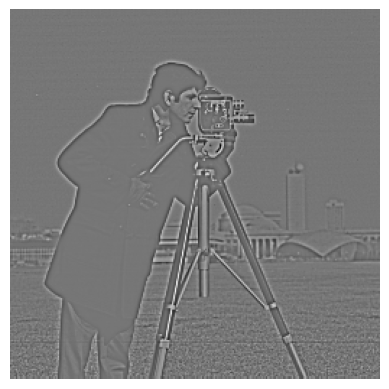

[[  0   0   0 ...   1   0  -1]
 [  0   0   0 ...   2   1   0]
 [ -1  -1   0 ...  -1  -1   0]
 ...
 [  0  -6   1 ...  -4 -11 -12]
 [ -1  -6  -8 ...  -7   1   6]
 [  3   7   7 ...   8  14  12]]


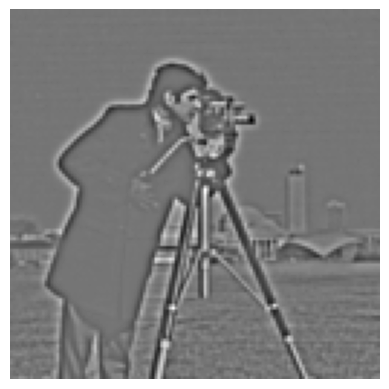

[[ 0 -1  0 ...  1  1  1]
 [-1 -1 -1 ... -1  0 -1]
 [-1  0  0 ... -2 -1 -2]
 ...
 [-2 -6  0 ...  1 -2 -1]
 [-4 -5 -1 ...  1  0  3]
 [-1  1  4 ...  0 -5  0]]


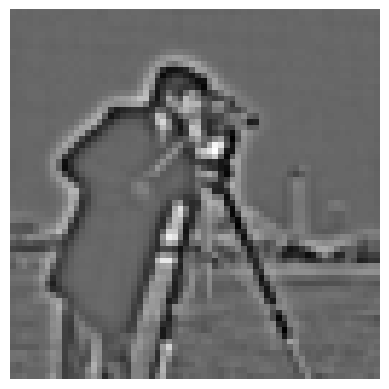

[[-1 -1  0 ... -1 -2 -2]
 [-1 -1  0 ... -1 -2 -3]
 [-3 -2 -1 ...  0 -1 -2]
 ...
 [ 0  0  5 ... -4 -3  4]
 [ 3  3  7 ... -5 -3  4]
 [-4 -1  6 ...  0  1  2]]


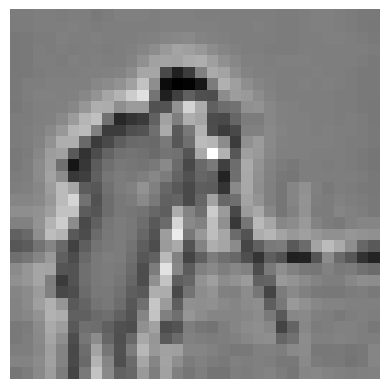

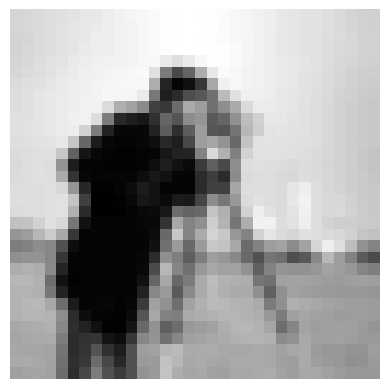

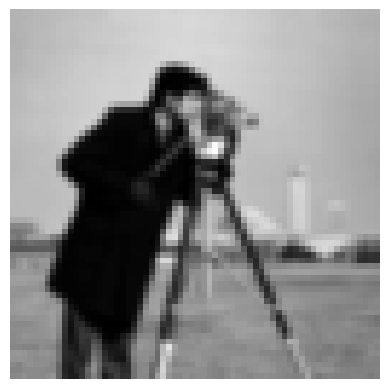

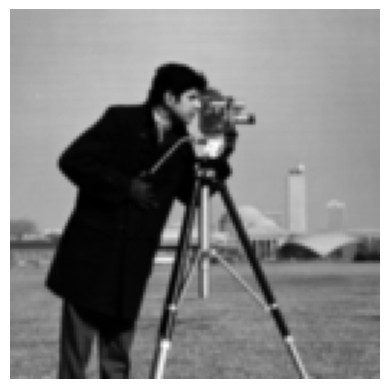

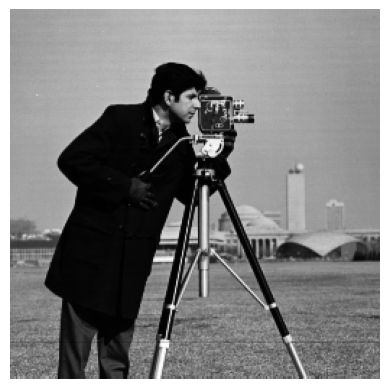

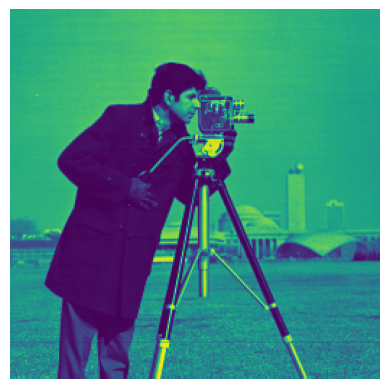

In [23]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
import os

# Define the filter kernel
kernel = (1/256)*np.array([[1, 4, 6, 4, 1],
                           [4, 16, 24, 16, 4],
                           [6, 24, 36, 24, 6],
                           [4, 16, 24, 16, 4],
                           [1, 4, 6, 4, 1]])

camera_img = cv2.imread(os.path.join('./', "cameraman.png"),cv2.IMREAD_GRAYSCALE)

        


def do_laplacian(n, camera_img, kernel):
    layers = dict()
    size = 0
    for i in range(n):
        if (i < n - 1):
            filtered = cv2.filter2D(src = camera_img, ddepth = -1, kernel = kernel)
            down = filtered[::2, ::2]
            up = np.zeros((filtered.shape[0], filtered.shape[1]))
            up[::2, ::2] = down
            up = up.astype(np.uint8)
            filtered_u = cv2.filter2D(up, -1, kernel*4)
            layers[size] = cv2.subtract(camera_img, filtered_u, dtype=cv2.CV_16S)
            plt.imshow(layers[size], cmap = 'gray')
            plt.axis('off')
            plt.show()
            size += 1     
            camera_img = down
        else:
            layers[size] = camera_img
    return layers

def recreation(layers):
    size = len(layers)
    img = layers[size-1]
    for i in range(size-1)[::-1]:
        up = np.array(np.zeros((layers[i].shape[0], layers[i].shape[1])))
        up[::2, ::2] = img
        up = up.astype(np.uint8)
        filtered_u = cv2.filter2D(src = up, ddepth = -1, kernel = 4*kernel)
        img = filtered_u + layers[i]
        plt.imshow(img, cmap = 'gray')
        plt.axis('off')
        plt.show()
    return img  
            
layers = do_laplacian(5, camera_img, kernel)
img = recreation(layers)
plt.imshow(camera_img)
plt.axis('off')
plt.show()


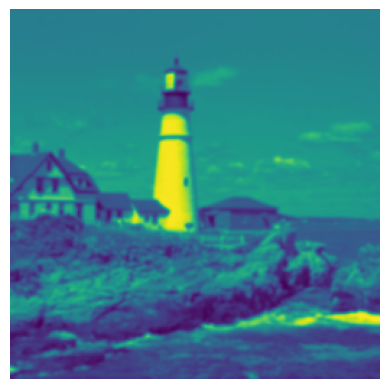

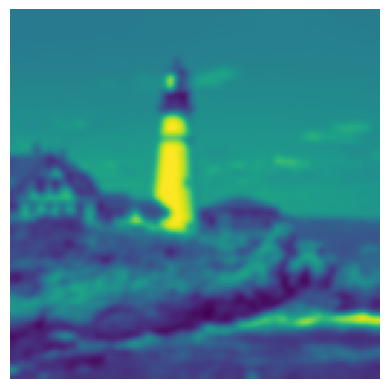

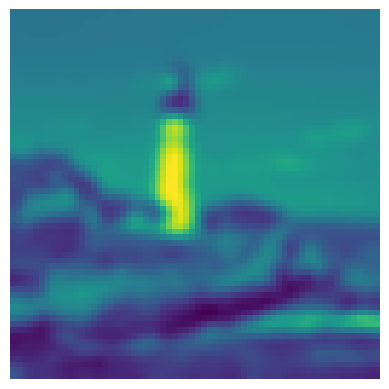

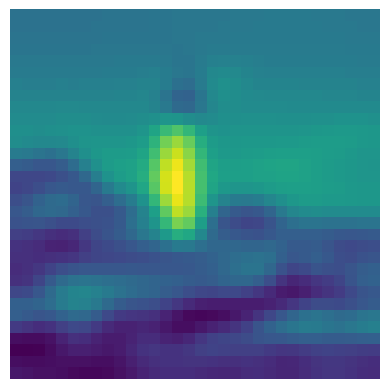

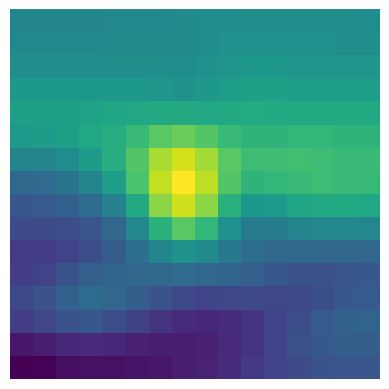

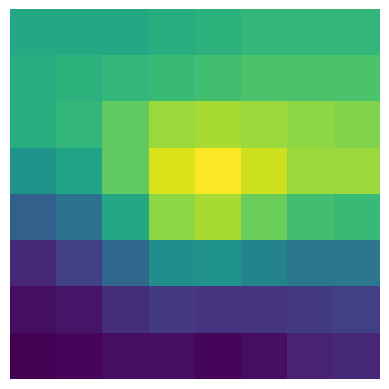

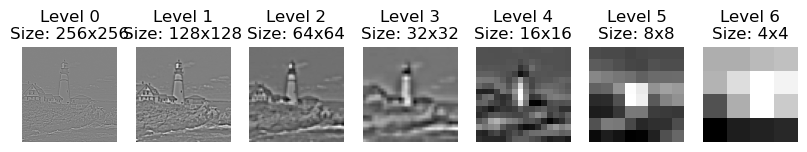

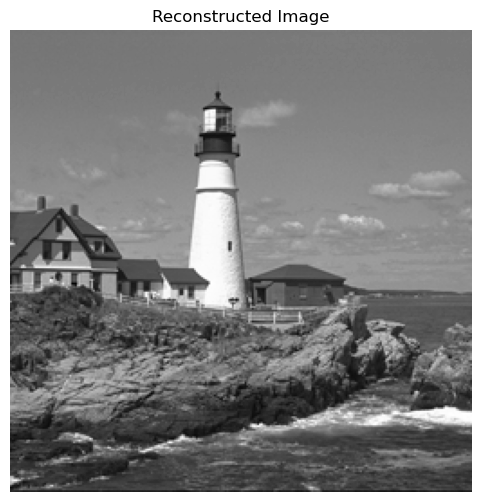

In [16]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt

# Define the filter kernel
kernel = (1/256)*np.array([[1, 4, 6, 4, 1],
                           [4, 16, 24, 16, 4],
                           [6, 24, 36, 24, 6],
                           [4, 16, 24, 16, 4],
                           [1, 4, 6, 4, 1]])

# import the image
original = cv2.imread(os.path.join('./', "kodim21.png"),cv2.IMREAD_GRAYSCALE)
# specify how many levels
num_levels = 7

# creates laplacian pyramid
def create_laplacian_pyramid(input_img, n):
    pyramid = []
    for i in range(n):
        if i < n - 1:
            # apply the gaussian filter to the input image
            filtered = cv2.filter2D(input_img, -1, kernel)
            # we downsample it by taking every second row/column pixel
            downsample = filtered[::2, ::2]
            # upsample it by initialising just zeros, then putting downsampled pixels into every second row/column pixel
            upsample = np.zeros((input_img.shape[0], input_img.shape[1]))
            upsample[::2, ::2] = downsample
            # apply filter onto the upsample with 5x5 kernel
            upsample_filtered = cv2.filter2D(upsample, -1, kernel*4)
            # subtract recreated from original
            laplacian = input_img - upsample_filtered
            input_img = downsample
        else:
            laplacian = input_img
        pyramid.append(laplacian)
    return pyramid

# reconstructs an image from the pyramid
def reconstruct_image(pyramid):
    n = len(pyramid)
    # set the image to be the last layer
    image = pyramid[-1]
    for i in range(n - 2, -1, -1):
        # inject zeros into every second row/column of image
        upsampled_image = np.zeros((image.shape[0] * 2, image.shape[1] * 2))
        upsampled_image[::2, ::2] = image
        # filter it with 4 x g
        upsampled_image_filtered = cv2.filter2D(upsampled_image, -1, 4 * kernel)
        # store reconstruction from previous layer with next layer
        image = upsampled_image_filtered + pyramid[i]
    return image

# call the two functions
laplacian_pyramid = create_laplacian_pyramid(original, num_levels)
reconstructed_image = reconstruct_image(laplacian_pyramid)

# plot the levels of the pyramid
plt.figure(figsize=(10, 5))
for i in range(num_levels):
    plt.subplot(1, num_levels, i+1)
    plt.imshow(laplacian_pyramid[i], cmap='gray')
    plt.title(f"Level {i}\nSize: {laplacian_pyramid[i].shape[1]}x{laplacian_pyramid[i].shape[0]}")
    plt.axis('off')
plt.show()

# plot the final reconstruction
plt.figure(figsize=(6, 6))
plt.imshow(reconstructed_image, cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()

### 2. Quantization and compression

### 3. Evaluation in the frequency domain